In [ ]:
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path to the dataset directory in Google Drive
dataset_dir = '/content/drive/My Drive/braintumordataset'

# List files in the dataset directory
file_list = os.listdir(dataset_dir)

print(file_list[:5])

['Testing', 'Training']


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
test_data_dir='/content/drive/MyDrive/braintumordataset/Testing'
train_data_dir = '/content/drive/MyDrive/braintumordataset/Training'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define the image size and batch size
img_size = (150, 150)
batch_size = 32

# Path to the directories containing training and testing data
train_data_dir = "/content/drive/MyDrive/braintumordataset/Training"
test_data_dir = "/content/drive/MyDrive/braintumordataset/Testing"

# Create an ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
)

# Load and preprocess the testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
images,labels=next(train_generator)
labels

array([1., 1., 1., 3., 3., 3., 1., 1., 1., 3., 3., 3., 1., 3., 1., 2., 0.,
       2., 3., 1., 3., 1., 0., 0., 2., 3., 3., 1., 1., 0., 3., 1.],
      dtype=float32)

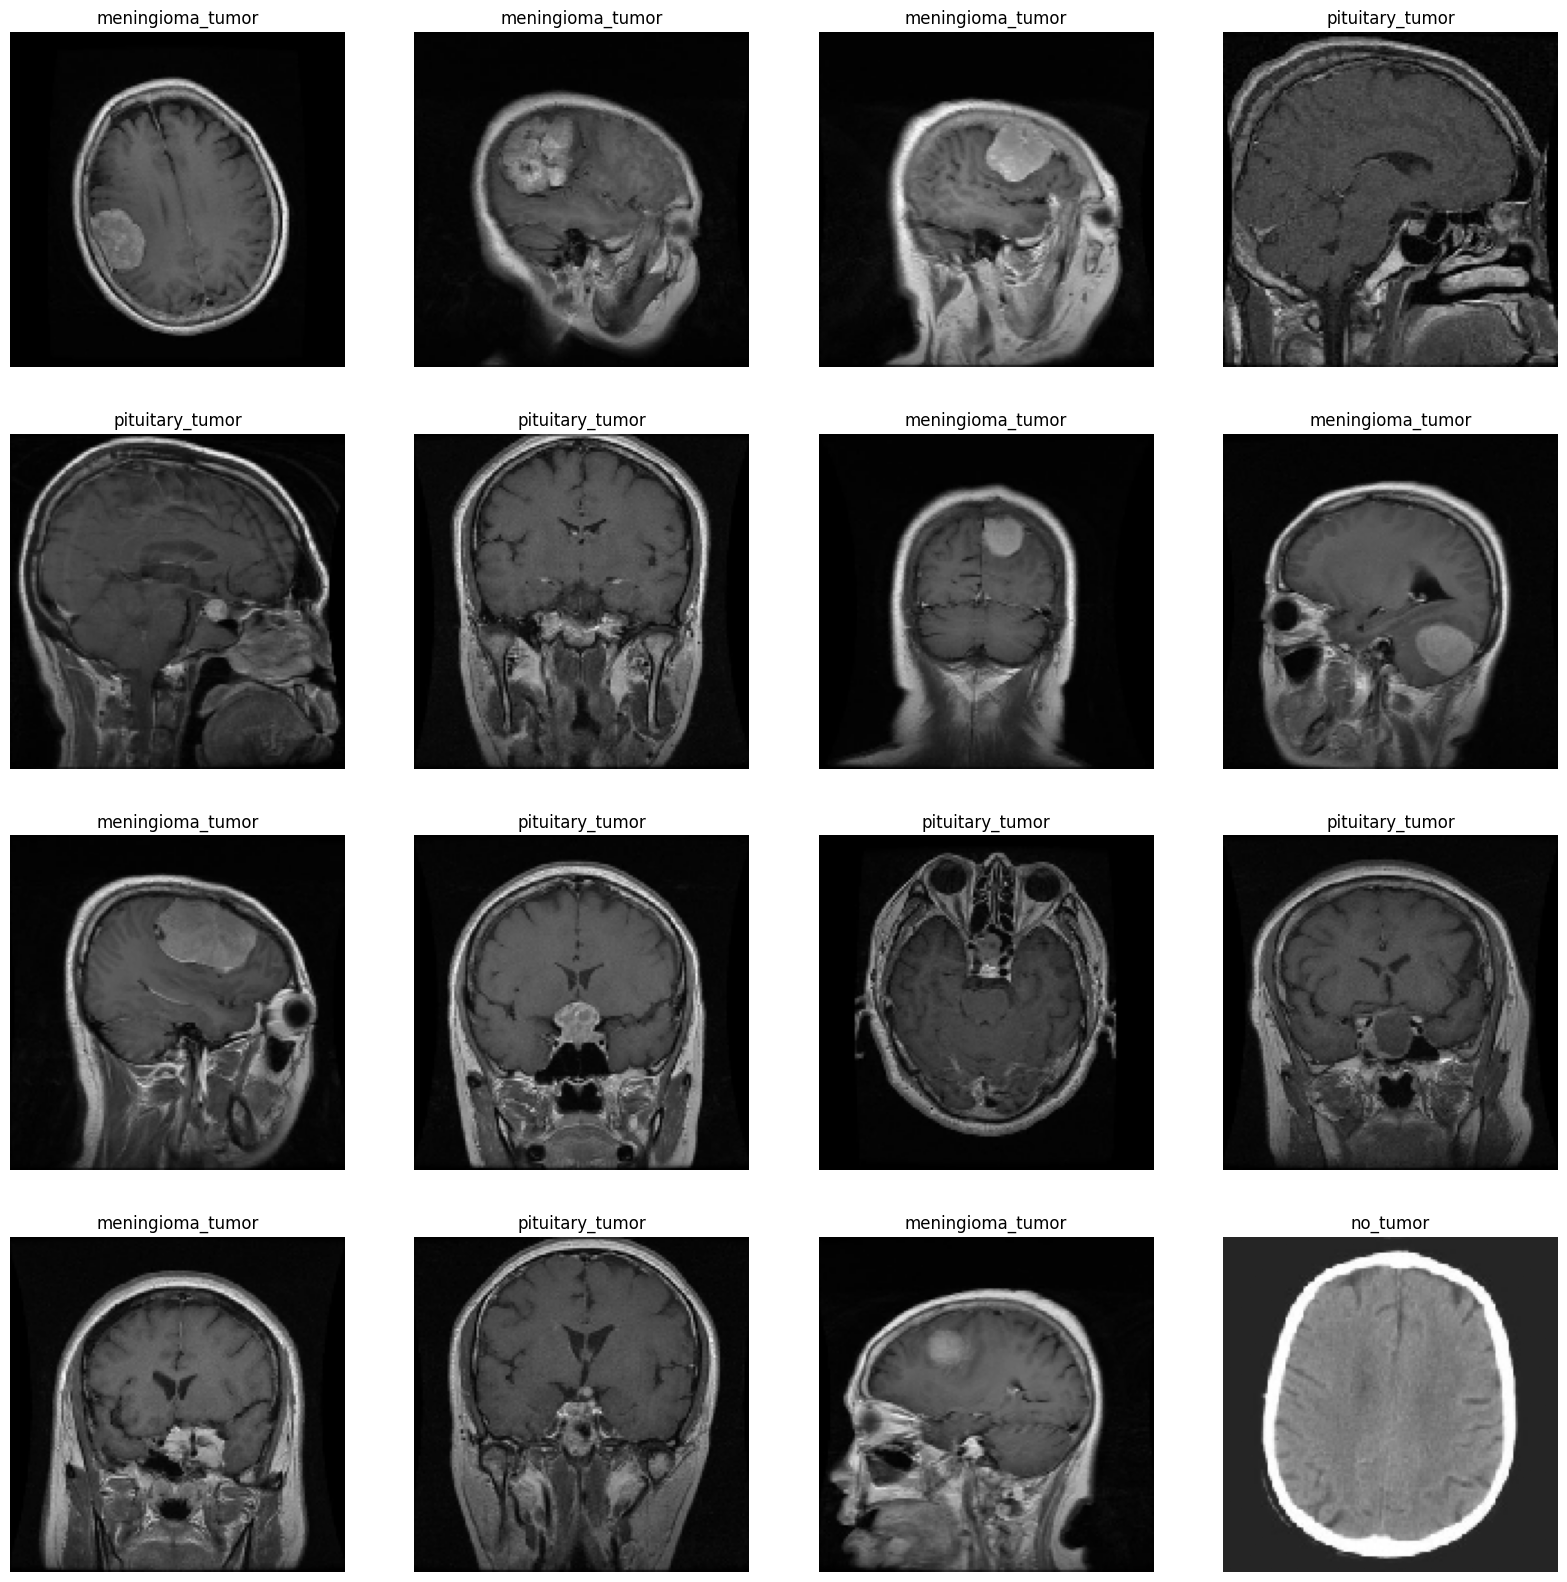

In [ ]:
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]
    plt.imshow(image)
    index = labels[i]
    class_name = class_names[int(index)]
    plt.title(class_name , fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# split image and labels for handling imbalance

X_train_R, y_train_R = [], []

for _ in range(len(train_generator)):
    images, labels = train_generator.next()
    X_train_R.extend(images)
    y_train_R.extend(labels)

X_train_R = np.array(X_train_R)
y_train_R = np.array(y_train_R)

In [ ]:
# for Testing models

X_test, y_test = [], []

for _ in range(len(test_generator)):
    images, labels = test_generator.next()
    X_test.extend(images)
    y_test.extend(labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# current shape of dataset
X_train_R.shape,y_train_R.shape,X_test.shape,y_test.shape

((2870, 150, 150, 3), (2870,), (394, 150, 150, 3), (394,))

In [ ]:
# clearly see imbalanced counts
np.bincount(y_train_R.astype(int))

array([829, 822, 398, 821])

In [ ]:
# Flatten the images
X_train_flatten = X_train_R.reshape(X_train_R.shape[0], -1)

# Apply SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flatten, y_train_R)

# Reshape the synthetic instances back into the original image format
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_R.shape[1], X_train_R.shape[2], X_train_R.shape[3])

In [ ]:
# After smote data shape
X_train_resampled.shape,y_train_resampled.shape,X_test.shape,y_test.shape

((3316, 150, 150, 3), (3316,), (394, 150, 150, 3), (394,))

In [ ]:
 #After smote label counts
np.bincount(y_train_resampled.astype(int))

array([829, 829, 829, 829])

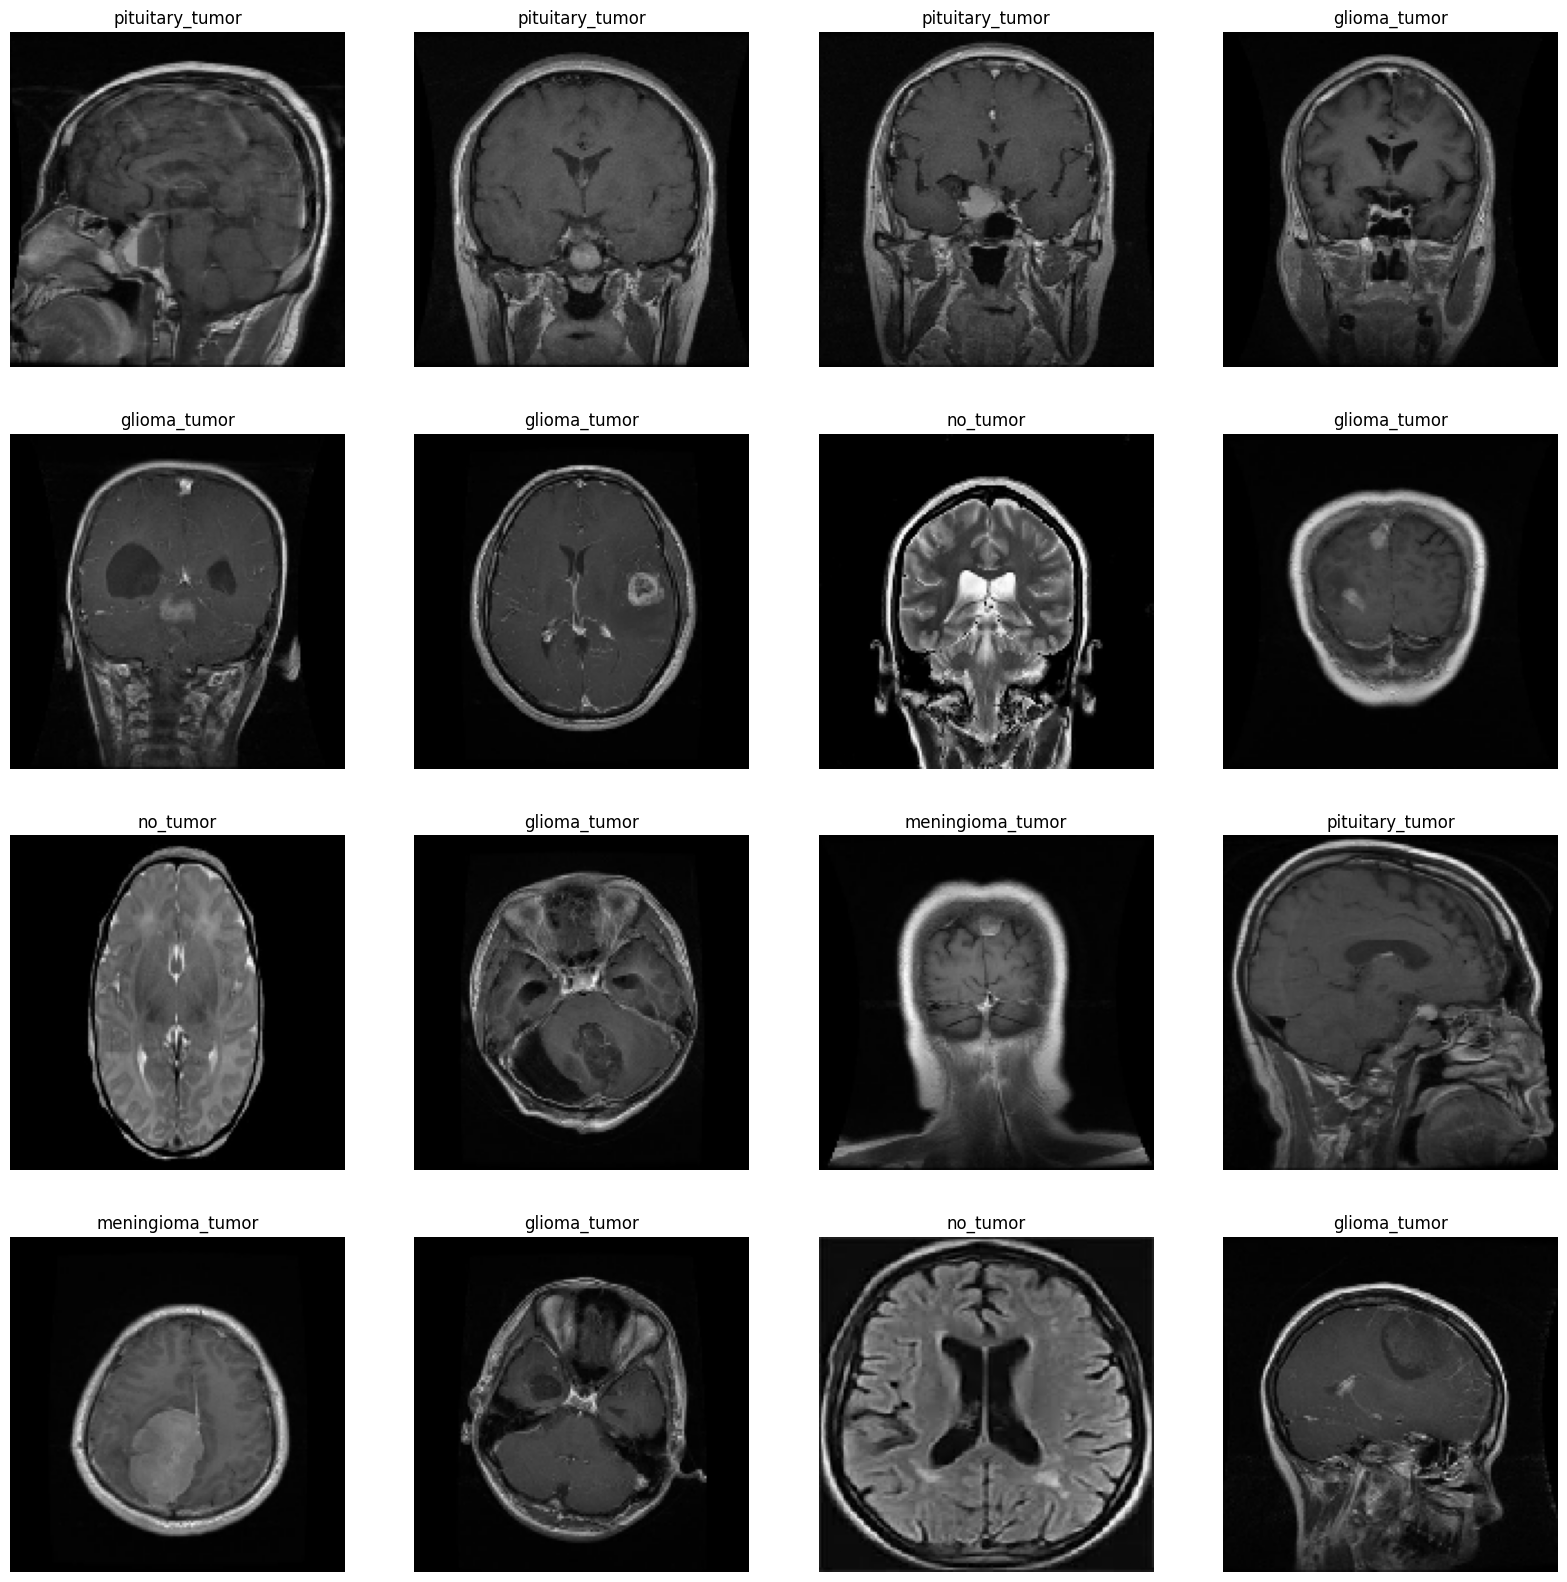

In [ ]:
# visualise new data and its labels
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = X_train_resampled[i]
    plt.imshow(image)
    index = y_train_resampled[i]
    class_name = class_names[int(index)]
    plt.title(class_name , fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, random_state=42)

In [ ]:
# check scaled or not
X_train.max()

1.0

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2321, 150, 150, 3), (995, 150, 150, 3), (2321,), (995,))

In [ ]:
# Model building

model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(img_size[0], img_size[0], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(22, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(12, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(867, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 22)        6358      
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 22)        88        
 chNormalization)                                                
                                                        

In [ ]:
model.compile(optimizer='Adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    batch_size=batch_size,
    verbose=1,
    epochs=20,
)

Epoch 1/20
73/73 [==============================] - 11s 47ms/step - loss: 1.2574 - accuracy: 0.7079 - val_loss: 3.6421 - val_accuracy: 0.2442
Epoch 2/20
73/73 [==============================] - 2s 26ms/step - loss: 0.3724 - accuracy: 0.8574 - val_loss: 5.4480 - val_accuracy: 0.2342
Epoch 3/20
73/73 [==============================] - 2s 25ms/step - loss: 0.2258 - accuracy: 0.9151 - val_loss: 6.0194 - val_accuracy: 0.2342
Epoch 4/20
73/73 [==============================] - 2s 29ms/step - loss: 0.1432 - accuracy: 0.9483 - val_loss: 5.6804 - val_accuracy: 0.2392
Epoch 5/20
73/73 [==============================] - 2s 30ms/step - loss: 0.1338 - accuracy: 0.9487 - val_loss: 2.0222 - val_accuracy: 0.5427
Epoch 6/20
73/73 [==============================] - 2s 26ms/step - loss: 0.0823 - accuracy: 0.9694 - val_loss: 0.7729 - val_accuracy: 0.7849
Epoch 7/20
73/73 [==============================] - 2s 25ms/step - loss: 0.0685 - accuracy: 0.9767 - val_loss: 0.7886 - val_accuracy: 0.8030
Epoch 8/20
7

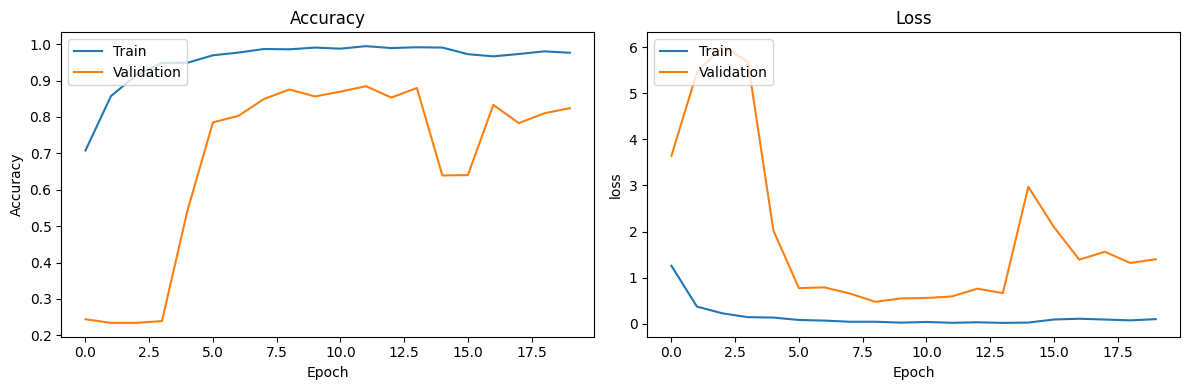

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

13/13 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.11      0.20       100
         1.0       0.54      0.77      0.64       115
         2.0       0.48      0.91      0.63       105
         3.0       0.94      0.20      0.33        74

    accuracy                           0.54       394
   macro avg       0.74      0.50      0.45       394
weighted avg       0.71      0.54      0.47       394



In [ ]:
import pickle

In [ ]:
with open('model_pickle','wb') as f:
  pickle.dump(model,f)

In [ ]:
with open('model_pickle','rb') as f:
  mp= pickle.load(f)

In [ ]:
pickle.dump(model,open('/content/model_saved','wb'))

In [ ]:
with open('model_pickle','rb') as f:
  mp= pickle.load(f)